In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [15]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

In [16]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/1.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,22.041608
1,22.048000
2,22.047176
3,22.042408
4,22.049328
...,...
38875,22.316160
38876,22.305744
38877,22.318160
38878,22.310040


In [17]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment5/online-learning-DLinear']

In [18]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)

        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))

        return x

In [19]:
class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size,stride = 1)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)

        res = x - moving_mean 
        # Classical ma중에서 additive model

        return res,moving_mean

In [20]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        
        # Decomposition Kernel Size
        small_kernel_size = 3  
        big_kernel_size = 65
        
        self.decomposition1 = series_decomp(small_kernel_size)
        self.decomposition2 = series_decomp(big_kernel_size)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        
       
        # 현재는 특성 각각에 별도의 layer를 두지 말자고 하면 하나씩의 Layer만 있으면 됨
        self.Linear_Seasonal = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_Trend = nn.Linear(2*self.seq_len,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init1,trend_init1 = self.decomposition1(x)
        seasonal_init2,trend_init2 = self.decomposition2(x)
        seasonal_init,trend_init = torch.cat([seasonal_init1,seasonal_init2],
                                             dim=2).to(self.device),torch.cat([trend_init1,
                                                                               trend_init2],dim=2).to(self.device)        
        seasonal_output = self.Linear_Seasonal(seasonal_init)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [21]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [22]:
torch.manual_seed(42)

In [23]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

In [24]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
# scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 1.005 ** epoch,verbose = True)
#                                        # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

In [25]:
torch.manual_seed(42)

In [26]:
out_list = []
loss_list = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()        
    #scheduler.step() #schedular update        
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

smape 2.923487884520787 %
smape 2.09094630712262 %
smape 1.2295824196666196 %
smape 0.42366455003587883 %
smape 0.12990804755725294 %
smape 0.11074311445958705 %
smape 0.09169554973207687 %
smape 0.07761229592789379 %
smape 0.06943587123549799 %
smape 0.06502283736723012 %
smape 0.06219830105968952 %
smape 0.05968764049293098 %
smape 0.05873894920587616 %
smape 0.057470673662528664 %
smape 0.056633761834097227 %
smape 0.05535950672326675 %
smape 0.054876614048497 %
smape 0.05389214716974254 %
smape 0.054168879090738885 %
smape 0.0530096696235637 %
smape 0.05326565576149478 %
smape 0.05212252361704024 %
smape 0.05246410702902562 %
smape 0.05163271330727254 %
smape 0.05229746329115447 %
smape 0.051087389863674844 %
smape 0.051663252227185354 %
smape 0.050756069787298685 %
smape 0.05145994040227293 %
smape 0.05038334912489773 %
smape 0.05099938204529019 %
smape 0.050174262339238364 %
smape 0.05084278225120599 %
smape 0.04984643926765028 %
smape 0.050536780786627024 %
smape 0.0495664728328

In [27]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.026159163720791412 %
SMAPE 0.0032761340810907313 %
SMAPE 0.016076223994843986 %
SMAPE 0.014335952352382721 %
SMAPE 0.002884825570532712 %
SMAPE 0.032091695071812865 %
SMAPE 0.00879955277434874 %
SMAPE 0.030344754925977213 %
SMAPE 0.0053240888796892705 %
SMAPE 0.004509347108296424 %
SMAPE 0.0021210210237541105 %
SMAPE 0.00553948584263253 %
SMAPE 0.04640223651779252 %
SMAPE 0.01690290306081721 %
SMAPE 0.013331948087227374 %
SMAPE 0.0175751527968373 %
SMAPE 0.009922328587492757 %
SMAPE 0.009750841153163492 %
SMAPE 0.02372383566043368 %
SMAPE 0.007584936526498609 %
SMAPE 0.02731445082281425 %
SMAPE 0.011826272483205003 %
SMAPE 0.04230805517494218 %
SMAPE 0.0032739715753109526 %
SMAPE 0.036825554639790425 %
SMAPE 0.03220502899328892 %
SMAPE 0.004838625058027901 %
SMAPE 0.002327361083814594 %
SMAPE 0.09868297136290494 %
SMAPE 0.007444430939273162 %
SMAPE 0.016660621510624196 %
SMAPE 0.026654071792563627 %
SMAPE 0.00903940383320645 %
SMAPE 0.0026581129095006872 %
SMAPE 0.0125216194653

SMAPE 0.0047919000629690345 %
SMAPE 0.004260468678097595 %
SMAPE 0.015545003441502558 %
SMAPE 0.02433641815621712 %
SMAPE 0.002713023084766064 %
SMAPE 0.027085047189530087 %
SMAPE 0.004541466483068746 %
SMAPE 0.01412202412143415 %
SMAPE 0.005991395048745574 %
SMAPE 0.009845099262264512 %
SMAPE 0.0061845214543154725 %
SMAPE 0.006867942785703463 %
SMAPE 0.009430797701014626 %
SMAPE 0.002988862043778795 %
SMAPE 0.010196705056614519 %
SMAPE 0.00627899512409158 %
SMAPE 0.0036330076119810424 %
SMAPE 0.004268567714746041 %
SMAPE 0.0030344152055477025 %
SMAPE 0.0031388888256884684 %
SMAPE 0.005512573885681604 %
SMAPE 0.0021596077517642698 %
SMAPE 0.003692084618933223 %
SMAPE 0.0005422282712004289 %
SMAPE 0.016874532920326146 %
SMAPE 0.004712574444965867 %
SMAPE 0.01042868515844475 %
SMAPE 0.012182357023050372 %
SMAPE 0.024133264699209178 %
SMAPE 0.022582146399258818 %
SMAPE 0.015021796081612138 %
SMAPE 0.005296405754734224 %
SMAPE 0.018174224054405386 %
SMAPE 0.0026005785883000954 %
SMAPE 0.00

SMAPE 0.004718988248441747 %
SMAPE 0.004996265376291831 %
SMAPE 0.016593937667494174 %
SMAPE 0.009568407762742481 %
SMAPE 0.004442647389879539 %
SMAPE 0.005791831535134406 %
SMAPE 0.015595934174513102 %
SMAPE 0.03696650658315548 %
SMAPE 0.011281604089106168 %
SMAPE 0.0017090766635305956 %
SMAPE 0.007014821341343236 %
SMAPE 0.0015679080022152903 %
SMAPE 0.008852816743214476 %
SMAPE 0.009585855251856401 %
SMAPE 0.011633959530058746 %
SMAPE 0.006751427510977237 %
SMAPE 0.001449276279096523 %
SMAPE 0.01294172542935712 %
SMAPE 0.020130011261812797 %
SMAPE 0.005726795465818668 %
SMAPE 0.01107941716827554 %
SMAPE 0.001569033557302646 %
SMAPE 0.0025400188269202317 %
SMAPE 0.0012947476194185015 %
SMAPE 0.006366887604123407 %
SMAPE 0.0021079242054327096 %
SMAPE 0.011093620814108363 %
SMAPE 0.017246447457750946 %
SMAPE 0.009527933341587413 %
SMAPE 0.0019116298760692985 %
SMAPE 0.0041608368946910446 %
SMAPE 0.01465641497696879 %
SMAPE 0.004238133950430267 %
SMAPE 0.010010529982423577 %
SMAPE 0.003

SMAPE 0.003812110653143464 %
SMAPE 0.0025957606856650273 %
SMAPE 0.004495529921953789 %
SMAPE 0.04950883429773967 %
SMAPE 0.0040024500062116886 %
SMAPE 0.01866998811499343 %
SMAPE 0.006333674852839977 %
SMAPE 0.002500971851304712 %
SMAPE 0.00203745015812018 %
SMAPE 0.0008393239223210003 %
SMAPE 0.005298503211065508 %
SMAPE 0.009493768591966045 %
SMAPE 0.004153982357593122 %
SMAPE 0.004145953643671874 %
SMAPE 0.01990823163458799 %
SMAPE 0.010370172670320699 %
SMAPE 0.005553154705353336 %
SMAPE 0.0032510363359961048 %
SMAPE 0.02804260078346488 %
SMAPE 0.006588842941795291 %
SMAPE 0.0022747678349333 %
SMAPE 0.012082135695891338 %
SMAPE 0.006529428974431539 %
SMAPE 0.0011773484277242119 %
SMAPE 0.007412814218355379 %
SMAPE 0.006200776485016491 %
SMAPE 0.01567950649160821 %
SMAPE 0.0022883352671669854 %
SMAPE 0.021131960229240576 %
SMAPE 0.004162927509000269 %
SMAPE 0.0047681475250556105 %
SMAPE 0.010150326704547297 %
SMAPE 0.009461232607861803 %
SMAPE 0.01733537707266919 %
SMAPE 0.01553390

SMAPE 0.003120098421803164 %
SMAPE 0.011976992526498975 %
SMAPE 0.013941831182478381 %
SMAPE 0.00670221642621982 %
SMAPE 0.010663528308683112 %
SMAPE 0.0028428708473029474 %
SMAPE 0.0066574459837625 %
SMAPE 0.00846863092010608 %
SMAPE 0.02545872751824163 %
SMAPE 0.018006943621571736 %
SMAPE 0.008011923574997581 %
SMAPE 0.0051699268602192205 %
SMAPE 0.010803740668002604 %
SMAPE 0.005371143058539474 %
SMAPE 0.002754000618743646 %
SMAPE 0.0011715257331843532 %
SMAPE 0.017097557996351043 %
SMAPE 0.007647999013727258 %
SMAPE 0.010893748886900312 %
SMAPE 0.012924193348226254 %
SMAPE 0.0037807479465143956 %
SMAPE 0.0032658716582503185 %
SMAPE 0.0025652198815180327 %
SMAPE 0.018769346710236334 %
SMAPE 0.0032706299784379667 %
SMAPE 0.005823906217500507 %
SMAPE 0.0032851765023735875 %
SMAPE 0.0032865085786397685 %
SMAPE 0.0069272092010805855 %
SMAPE 0.005429505973324922 %
SMAPE 0.0015310702528665843 %
SMAPE 0.00808665842356504 %
SMAPE 0.003406266956972104 %
SMAPE 0.017148546528574116 %
SMAPE 0.0

SMAPE 0.006141782103682658 %
SMAPE 0.012060638402431323 %
SMAPE 0.011025419230577427 %
SMAPE 0.0022547474571297244 %
SMAPE 0.0008962669243146593 %
SMAPE 0.00748546983591325 %
SMAPE 0.005051731608688215 %
SMAPE 0.0012669757951044858 %
SMAPE 0.003258419285771197 %
SMAPE 0.009912984796962121 %
SMAPE 0.004650244142467841 %
SMAPE 0.007127197929996499 %
SMAPE 0.009238651049912505 %
SMAPE 0.007481963635825649 %
SMAPE 0.0023182658248970256 %
SMAPE 0.03241698523544301 %
SMAPE 0.016120711775684526 %
SMAPE 0.021173768028226903 %
SMAPE 0.017633943723808443 %
SMAPE 0.0094356055891609 %
SMAPE 0.0030886404942407353 %
SMAPE 0.007376683605684775 %
SMAPE 0.016045367677804734 %
SMAPE 0.019789685192776574 %
SMAPE 0.008586774104003325 %
SMAPE 0.018156360874854727 %
SMAPE 0.008238485751832059 %
SMAPE 0.007194045684187245 %
SMAPE 0.03059613892537527 %
SMAPE 0.010360755900592267 %
SMAPE 0.003769645341890282 %
SMAPE 0.002654333636485262 %
SMAPE 0.0323639632531183 %
SMAPE 0.011612303017336956 %
SMAPE 0.00712502

SMAPE 0.005916413196018766 %
SMAPE 0.008788375809331228 %
SMAPE 0.015550099519984428 %
SMAPE 0.013272595321424772 %
SMAPE 0.015843932802958705 %
SMAPE 0.010115609388606117 %
SMAPE 0.003965315828082794 %
SMAPE 0.0060218048454458994 %
SMAPE 0.008682936696786214 %
SMAPE 0.0018797846492759618 %
SMAPE 0.009099495604743879 %
SMAPE 0.0012527785091052124 %
SMAPE 0.008750264828805143 %
SMAPE 0.0032562445783241856 %
SMAPE 0.015157686570773876 %
SMAPE 0.0030473521020439875 %
SMAPE 0.008397203570339684 %
SMAPE 0.0035584205911618483 %
SMAPE 0.0075496504304908285 %
SMAPE 0.0017623383998284223 %
SMAPE 0.002604441917810618 %
SMAPE 0.006453094852020058 %
SMAPE 0.006598850542104629 %
SMAPE 0.013061125287912036 %
SMAPE 0.00243313603380102 %
SMAPE 0.004963341371443164 %
SMAPE 0.0037828842054494776 %
SMAPE 0.004904256204383728 %
SMAPE 0.0050758244114064155 %
SMAPE 0.009083169015553949 %
SMAPE 0.003259358030291537 %
SMAPE 0.008832025357492057 %
SMAPE 0.0015243038085372973 %
SMAPE 0.008499688515470893 %
SMAP

SMAPE 0.004969065116007698 %
SMAPE 0.01117330182700016 %
SMAPE 0.007446930409770403 %
SMAPE 0.0009886623012391738 %
SMAPE 0.00045430334147056323 %
SMAPE 0.03769436440393292 %
SMAPE 0.002625088129924791 %
SMAPE 0.011575981466648955 %
SMAPE 0.005904699935371127 %
SMAPE 0.014276312521189995 %
SMAPE 0.0024679414300834424 %
SMAPE 0.0038931699224491467 %
SMAPE 0.003239336533738424 %
SMAPE 0.016565337622523657 %
SMAPE 0.001495997089989487 %
SMAPE 0.001331917323732057 %
SMAPE 0.01935021742647791 %
SMAPE 0.006057170452436367 %
SMAPE 0.0038335536884943617 %
SMAPE 0.012431476611709513 %
SMAPE 0.02299883246655554 %
SMAPE 0.021159417944623726 %
SMAPE 0.010472062819040673 %
SMAPE 0.006742889304973687 %
SMAPE 0.006179121820821366 %
SMAPE 0.0030815241972277363 %
SMAPE 0.0034065438625106026 %
SMAPE 0.03146286564128786 %
SMAPE 0.018210388136694178 %
SMAPE 0.010400463174818242 %
SMAPE 0.0035903997714967772 %
SMAPE 0.006212783793905885 %
SMAPE 0.005096408730878466 %
SMAPE 0.00833364424767069 %
SMAPE 0.014

SMAPE 0.002761919471311103 %
SMAPE 0.002908514059967615 %
SMAPE 0.02882533999471093 %
SMAPE 0.004799860788921251 %
SMAPE 0.019066289481315835 %
SMAPE 0.009174642397056232 %
SMAPE 0.01974503755582191 %
SMAPE 0.007429712207965622 %
SMAPE 0.005900879541627546 %
SMAPE 0.03981515206771746 %
SMAPE 0.00845836387144061 %
SMAPE 0.008709601629277586 %
SMAPE 0.005808300574791758 %
SMAPE 0.015999634450906797 %
SMAPE 0.017688604922028617 %
SMAPE 0.012233354821859166 %
SMAPE 0.0020771614845642716 %
SMAPE 0.0144379863731956 %
SMAPE 0.00454804444326129 %
SMAPE 0.004974742529697096 %
SMAPE 0.014897015132021352 %
SMAPE 0.004677671390204807 %
SMAPE 0.012712660727174809 %
SMAPE 0.012387369978284823 %
SMAPE 0.006601351182716542 %
SMAPE 0.028720425719257037 %
SMAPE 0.011389025429984656 %
SMAPE 0.003859508276576662 %
SMAPE 0.01282303275331742 %
SMAPE 0.0059195335744703925 %
SMAPE 0.024063369877126206 %
SMAPE 0.015463981836816743 %
SMAPE 0.004175853931407403 %
SMAPE 0.003134752965650023 %
SMAPE 0.019483431620

SMAPE 0.0020795724126756454 %
SMAPE 0.01664249898320236 %
SMAPE 0.03373493773695202 %
SMAPE 0.020202695534749182 %
SMAPE 0.008235052046302371 %
SMAPE 0.0018000835017630832 %
SMAPE 0.0050729955930819415 %
SMAPE 0.006604053607475179 %
SMAPE 0.030244052484249547 %
SMAPE 0.007304132048773226 %
SMAPE 0.017895243366098157 %
SMAPE 0.008637821954579294 %
SMAPE 0.021262557645137292 %
SMAPE 0.0020615617354451388 %
SMAPE 0.0022171716898355953 %
SMAPE 0.018975480380049703 %
SMAPE 0.01300708469682377 %
SMAPE 0.004869876495135372 %
SMAPE 0.0036329711231246615 %
SMAPE 0.006661137159838404 %
SMAPE 0.018904941317231305 %
SMAPE 0.0037122661528599115 %
SMAPE 0.00532536493005864 %
SMAPE 0.007762025407885176 %
SMAPE 0.04190250118458039 %
SMAPE 0.015391291369894587 %
SMAPE 0.0028868848605085873 %
SMAPE 0.02463225352944676 %
SMAPE 0.02059063486535706 %
SMAPE 0.032438190863786076 %
SMAPE 0.010693664252812596 %
SMAPE 0.01149852272782681 %
SMAPE 0.0073823997349222745 %
SMAPE 0.0267704278102201 %
SMAPE 0.0052370

SMAPE 0.004385814170021263 %
SMAPE 0.008807904722807791 %
SMAPE 0.024463026774185437 %
SMAPE 0.0037424850838476686 %
SMAPE 0.0073893243049099055 %
SMAPE 0.007477652640488941 %
SMAPE 0.013421177337988865 %
SMAPE 0.02582066879505618 %
SMAPE 0.004345077913569639 %
SMAPE 0.0037943789873224882 %
SMAPE 0.005060470665384287 %
SMAPE 0.004004923982733999 %
SMAPE 8.195627018809319 %
SMAPE 9.459190508932807 %
SMAPE 1.1917149161688485 %
SMAPE 12.217021048069 %
SMAPE 4.672069838270545 %
SMAPE 0.026277034927261408 %
SMAPE 3.802920756861568 %
SMAPE 0.6297570598371749 %
SMAPE 0.2504702333935711 %
SMAPE 0.5792801564093679 %
SMAPE 0.17878287256644398 %
SMAPE 0.23854673780488153 %
SMAPE 0.018187234560500087 %
SMAPE 0.27059462036959303 %
SMAPE 0.20142393293878058 %
SMAPE 0.0056719762842476484 %
SMAPE 0.2771691296904919 %
SMAPE 0.2115536151801507 %
SMAPE 0.09822875230523209 %
SMAPE 0.1238742867376459 %
SMAPE 0.23682460196232571 %
SMAPE 0.1125946689827515 %
SMAPE 0.13144228479154663 %
SMAPE 0.01684636995327

SMAPE 0.29504620606621756 %
SMAPE 0.8760189286231252 %
SMAPE 0.2027749195004276 %
SMAPE 0.051636074546422606 %
SMAPE 0.3851072570375891 %
SMAPE 0.3127967034766641 %
SMAPE 0.2531800742158907 %
SMAPE 0.7375749194288801 %
SMAPE 0.05779817676182119 %
SMAPE 0.7386221689994272 %
SMAPE 1.333440135116689 %
SMAPE 0.21310534021702665 %
SMAPE 0.16581409268712832 %
SMAPE 0.70999519365796 %
SMAPE 0.008242543348842446 %
SMAPE 0.0939657191729566 %
SMAPE 0.16974327782145338 %
SMAPE 0.18111735789966588 %
SMAPE 0.17443294213046556 %
SMAPE 0.5136161281655518 %
SMAPE 0.16241072559694203 %
SMAPE 0.01956193055775657 %
SMAPE 1.4102485373150557 %
SMAPE 0.010117271597522404 %
SMAPE 0.1359545067371073 %
SMAPE 0.8575105413110579 %
SMAPE 0.011905216316790757 %
SMAPE 0.12699105816182055 %
SMAPE 0.07460258219362004 %
SMAPE 0.028277225084366364 %
SMAPE 0.2578817412587 %
SMAPE 0.13003173030460857 %
SMAPE 0.10484877568205775 %
SMAPE 0.10310733709684428 %
SMAPE 0.15375303709834043 %
SMAPE 0.336473497294719 %
SMAPE 0.08

SMAPE 0.03745422318291958 %
SMAPE 0.08222389252000539 %
SMAPE 0.0024308130275727535 %
SMAPE 0.01054813969665247 %
SMAPE 0.07346828635974134 %
SMAPE 0.01046354101202951 %
SMAPE 0.014451669626055264 %
SMAPE 0.018727283776797776 %
SMAPE 0.08010820951130881 %
SMAPE 0.03814981963932951 %
SMAPE 0.021995685866784243 %
SMAPE 0.030610457136958757 %
SMAPE 0.0063957682565387594 %
SMAPE 0.012891816401349843 %
SMAPE 0.0795554448003486 %
SMAPE 0.09077520448687437 %
SMAPE 0.010735123720934325 %
SMAPE 0.02562407560679958 %
SMAPE 0.045099381095440094 %
SMAPE 0.008328712428919971 %
SMAPE 0.01502591841068579 %
SMAPE 0.015985097309688 %
SMAPE 0.011211952542169001 %
SMAPE 0.07068610498164674 %
SMAPE 0.005246500943613341 %
SMAPE 0.008196732507649074 %
SMAPE 0.07224250296383161 %
SMAPE 0.0438691328031382 %
SMAPE 0.002183563284397394 %
SMAPE 0.12926486967552364 %
SMAPE 0.033196360040619766 %
SMAPE 0.07550363066502541 %
SMAPE 0.06586687375181555 %
SMAPE 0.08317262648607482 %
SMAPE 0.0020576491231736327 %
SMAPE

SMAPE 0.008332862686387443 %
SMAPE 0.007518059663766508 %
SMAPE 0.0032352511829927266 %
SMAPE 0.007937517772006686 %
SMAPE 0.007406738207862417 %
SMAPE 0.0029200870122352285 %
SMAPE 0.007071317224699669 %
SMAPE 0.0031759632227590373 %
SMAPE 0.02674681249459354 %
SMAPE 0.00793879051161639 %
SMAPE 0.011325409570247302 %
SMAPE 0.0035550448537264856 %
SMAPE 0.011894479958982629 %
SMAPE 0.006179339038226317 %
SMAPE 0.016881307058383754 %
SMAPE 0.014964794880143018 %
SMAPE 0.005318778662278589 %
SMAPE 0.007623289630089403 %
SMAPE 0.004671266844070487 %
SMAPE 0.003358919625348733 %
SMAPE 0.01562969860742669 %
SMAPE 0.0076046217748739755 %
SMAPE 0.006045209760713988 %
SMAPE 0.01825697579312191 %
SMAPE 0.01518084483649318 %
SMAPE 0.005111179618211281 %
SMAPE 0.005103199736595343 %
SMAPE 0.0038319803675221924 %
SMAPE 0.009184296148717408 %
SMAPE 0.005761002917878955 %
SMAPE 0.004262494032843733 %
SMAPE 0.009891970846410914 %
SMAPE 0.008471836744263328 %
SMAPE 0.00711499608860322 %
SMAPE 0.005755

SMAPE 0.024161402233175977 %
SMAPE 0.019636058338683426 %
SMAPE 0.008417278231377168 %
SMAPE 0.01518895817875432 %
SMAPE 0.014108068789937535 %
SMAPE 0.028724787948704034 %
SMAPE 0.04441451351164005 %
SMAPE 0.0333657808253065 %
SMAPE 0.02913098786416413 %
SMAPE 0.006116073625008766 %
SMAPE 0.011517919349017802 %
SMAPE 0.006052283871667896 %
SMAPE 0.005967715274891816 %
SMAPE 0.004186646932794247 %
SMAPE 0.006481797029380232 %
SMAPE 0.025579385877563258 %
SMAPE 0.002184955203667016 %
SMAPE 0.004833012733342912 %
SMAPE 0.0033166287710599818 %
SMAPE 0.007331704962439289 %
SMAPE 0.0056969902363448455 %
SMAPE 0.002817154387962262 %
SMAPE 0.014029294425441208 %
SMAPE 0.02203729524065068 %
SMAPE 0.013420100161738448 %
SMAPE 0.03790333809678259 %
SMAPE 0.047887016711285924 %
SMAPE 0.007921786133735509 %
SMAPE 0.006193051294474117 %
SMAPE 0.020313867280947306 %
SMAPE 0.026624201824915872 %
SMAPE 0.020047238513939192 %
SMAPE 0.00796947759147315 %
SMAPE 0.018390078528511822 %
SMAPE 0.027678720530

SMAPE 0.011767099999758557 %
SMAPE 0.01581908737023241 %
SMAPE 0.006868172382581861 %
SMAPE 0.005369160101651005 %
SMAPE 0.0124812445736211 %
SMAPE 0.002894821522431812 %
SMAPE 0.002902366790465294 %
SMAPE 0.007903863658867749 %
SMAPE 0.010398125670036507 %
SMAPE 0.004608613835344499 %
SMAPE 0.006237765091441362 %
SMAPE 0.017565642709769236 %
SMAPE 0.030474263943233385 %
SMAPE 0.00573784610494954 %
SMAPE 0.03137391775089782 %
SMAPE 0.019036778047848202 %
SMAPE 0.013219888235994404 %
SMAPE 0.025512757014894305 %
SMAPE 0.012084776901701844 %
SMAPE 0.007630764300699867 %
SMAPE 0.019076554826938263 %
SMAPE 0.011068836078415245 %
SMAPE 0.00414770613821247 %
SMAPE 0.012102442323964624 %
SMAPE 0.005582198168667674 %
SMAPE 0.008297647808376496 %
SMAPE 0.02457378740425042 %
SMAPE 0.008651374139844847 %
SMAPE 0.003943868190916078 %
SMAPE 0.026806121908066412 %
SMAPE 0.030314386021018436 %
SMAPE 0.024319945437184742 %
SMAPE 0.003833612515165896 %
SMAPE 0.0019453621102059062 %
SMAPE 0.023459493536

SMAPE 0.003032406858210379 %
SMAPE 0.0049984975179881985 %
SMAPE 0.5351514818485157 %
SMAPE 0.9565523886485606 %
SMAPE 0.1405170940820426 %
SMAPE 0.10237089822373946 %
SMAPE 0.010641336241178578 %
SMAPE 0.0041518331039753775 %
SMAPE 0.03539269100912179 %
SMAPE 0.02376054604701494 %
SMAPE 0.02399070977617157 %
SMAPE 0.023936562010476337 %
SMAPE 0.028091684202763645 %
SMAPE 0.02810197611574949 %
SMAPE 0.025464095848633406 %
SMAPE 0.008365114828393416 %
SMAPE 0.0193160666576091 %
SMAPE 0.3311371400172902 %
SMAPE 0.1474043742680351 %
SMAPE 0.013411859858820208 %
SMAPE 0.024961189695204666 %
SMAPE 0.38974178434318674 %
SMAPE 0.8533965165261179 %
SMAPE 0.29029660994638107 %
SMAPE 0.004498833863280538 %
SMAPE 0.005352092355565219 %
SMAPE 0.002903175019810078 %
SMAPE 0.039443368168463167 %
SMAPE 0.01764328389253933 %
SMAPE 0.4120813213742167 %
SMAPE 0.20463898126217828 %
SMAPE 0.3030056678890105 %
SMAPE 0.29541352261730935 %
SMAPE 0.002377888147961471 %
SMAPE 0.01526973948250543 %
SMAPE 0.0467

SMAPE 0.019665931881213794 %
SMAPE 0.01587758449204557 %
SMAPE 0.007013793727651318 %
SMAPE 0.004480574677216964 %
SMAPE 0.02027039100158845 %
SMAPE 0.01312041080947779 %
SMAPE 0.0021405662719757856 %
SMAPE 0.007018655802738749 %
SMAPE 0.0049068565086400895 %
SMAPE 0.00884582688769342 %
SMAPE 0.029544513842324708 %
SMAPE 0.037214163922804744 %
SMAPE 0.014716569063466522 %
SMAPE 0.019100376393566876 %
SMAPE 0.0019026116036116036 %
SMAPE 0.003488855531543322 %
SMAPE 0.06757565292309664 %
SMAPE 0.025679364975871977 %
SMAPE 0.0036944709476784965 %
SMAPE 0.026645859244297302 %
SMAPE 0.005131235822830149 %
SMAPE 0.0625705272944117 %
SMAPE 0.1146832443043877 %
SMAPE 0.012155703174983046 %
SMAPE 0.007042393559089533 %
SMAPE 0.042522481759803554 %
SMAPE 0.02030172346769632 %
SMAPE 0.019760122036188932 %
SMAPE 0.047068385477956554 %
SMAPE 0.006324317035605987 %
SMAPE 0.010046419776955418 %
SMAPE 0.032559798117290484 %
SMAPE 0.01327718698549063 %
SMAPE 0.023908247699637286 %
SMAPE 0.0101111577841

SMAPE 0.06158231485119359 %
SMAPE 0.14986337249092685 %
SMAPE 0.033272398987492124 %
SMAPE 0.09808577176127642 %
SMAPE 0.015608514750738321 %
SMAPE 0.06260253013726924 %
SMAPE 0.08017953084663532 %
SMAPE 0.002612551406691921 %
SMAPE 0.11829762195705484 %
SMAPE 0.018304073329574067 %
SMAPE 0.13677074405438816 %
SMAPE 0.0804973715595736 %
SMAPE 0.24579999362049418 %
SMAPE 0.07899062664372991 %
SMAPE 0.013860689958590909 %
SMAPE 0.05547804963157432 %
SMAPE 0.016052933554391302 %
SMAPE 0.09411262392950448 %
SMAPE 0.019422827444536495 %
SMAPE 0.11917727007175927 %
SMAPE 0.004707653751893304 %
SMAPE 0.1554816803381982 %
SMAPE 0.004800126466761867 %
SMAPE 0.0957758938015445 %
SMAPE 0.034796631098629405 %
SMAPE 0.02540037711776222 %
SMAPE 0.006237057873534013 %
SMAPE 0.02203566952061209 %
SMAPE 0.15696288528488367 %
SMAPE 0.012214028806056376 %
SMAPE 0.05546298892147661 %
SMAPE 0.03709565198317932 %
SMAPE 0.08684028264283938 %
SMAPE 0.07952470618007368 %
SMAPE 0.010596411019477614 %
SMAPE 0.20

SMAPE 0.007126890470544822 %
SMAPE 0.004870346652353419 %
SMAPE 0.012208429210005534 %
SMAPE 0.003207887469613979 %
SMAPE 0.010304939322907103 %
SMAPE 0.0015032922903941426 %
SMAPE 0.024914333456308665 %
SMAPE 0.025440219356369198 %
SMAPE 0.012434357697031826 %
SMAPE 0.012972298397443183 %
SMAPE 0.005661364375725952 %
SMAPE 0.0022528606374692117 %
SMAPE 0.003768075181767472 %
SMAPE 0.018631720607686475 %
SMAPE 0.002714649805454883 %
SMAPE 0.017644658920289658 %
SMAPE 0.004932517954529203 %
SMAPE 0.012276865601734244 %
SMAPE 0.0034734510106773087 %
SMAPE 0.001378471944121884 %
SMAPE 0.002289344061068732 %
SMAPE 0.01681695718298215 %
SMAPE 0.018529457732370247 %
SMAPE 0.01343640413824687 %
SMAPE 0.014215452678627118 %
SMAPE 0.010564117249259652 %
SMAPE 0.003927344228941365 %
SMAPE 0.02695880332453271 %
SMAPE 0.009510098038617798 %
SMAPE 0.0019745767974086448 %
SMAPE 0.006422584897720186 %
SMAPE 0.004231421775898525 %
SMAPE 0.006376875500293977 %
SMAPE 0.005608091362660161 %
SMAPE 0.01519

SMAPE 0.024686105522278016 %
SMAPE 0.013305423684982998 %
SMAPE 0.027924267843786765 %
SMAPE 0.005264636207357398 %
SMAPE 0.0019351561875780021 %
SMAPE 0.03421343233823393 %
SMAPE 0.015318965329015556 %
SMAPE 0.02753080933740648 %
SMAPE 0.016909833703209642 %
SMAPE 0.022105204496483566 %
SMAPE 0.009792254078320184 %
SMAPE 0.009842551222611462 %
SMAPE 0.021011739317231104 %
SMAPE 0.029170013208840828 %
SMAPE 0.0015553892675939096 %
SMAPE 0.001302043630261096 %
SMAPE 0.0036706041223908414 %
SMAPE 0.02417185049310433 %
SMAPE 0.030580118799036878 %
SMAPE 0.0017061990907052405 %
SMAPE 0.008027654107195303 %
SMAPE 0.005848676271597242 %
SMAPE 0.004204244124281331 %
SMAPE 0.020164463013713885 %
SMAPE 0.022465839354708805 %
SMAPE 0.013431640564363079 %
SMAPE 0.001745999983313595 %
SMAPE 0.02227462162466054 %
SMAPE 0.02606170972259747 %
SMAPE 0.012312224093648185 %
SMAPE 0.003517156979654601 %
SMAPE 0.0051551441374613205 %
SMAPE 0.01769951902717537 %
SMAPE 0.0020230911236183147 %
SMAPE 0.012537

SMAPE 0.0038840293838831026 %
SMAPE 0.04054633910664052 %
SMAPE 0.009029633549289429 %
SMAPE 0.03056257646630911 %
SMAPE 0.004194059648511939 %
SMAPE 0.04510300157653546 %
SMAPE 0.041399038479767114 %
SMAPE 0.011759260922815429 %
SMAPE 0.0019877699910608726 %
SMAPE 0.018022995759622518 %
SMAPE 0.0024494496436204827 %
SMAPE 0.011909954599140349 %
SMAPE 0.04825493612332821 %
SMAPE 0.00710886008351963 %
SMAPE 0.002948208986111922 %
SMAPE 0.0031082261878765394 %
SMAPE 0.007183611852894955 %
SMAPE 0.0045158628211652285 %
SMAPE 0.01666035701508406 %
SMAPE 0.001877179325887823 %
SMAPE 0.003380306682572609 %
SMAPE 0.0033453870445399048 %
SMAPE 0.008378314413228338 %
SMAPE 0.002509173890302918 %
SMAPE 0.023049585371417436 %
SMAPE 0.008550879878882256 %
SMAPE 0.01787867221128181 %
SMAPE 0.018537688760432047 %
SMAPE 0.009479969027665902 %
SMAPE 0.012529325982427508 %
SMAPE 0.0020368817137068618 %
SMAPE 0.014792907453909265 %
SMAPE 0.0033158868113218887 %
SMAPE 0.007786266017589583 %
SMAPE 0.00469

SMAPE 0.013260076925860174 %
SMAPE 0.0036281722284456923 %
SMAPE 0.02087545443512795 %
SMAPE 0.0298731455932284 %
SMAPE 0.0028776367283143145 %
SMAPE 0.006503550730286633 %
SMAPE 0.008998262997181428 %
SMAPE 0.0015317444505527078 %
SMAPE 0.0024175019775185547 %
SMAPE 0.023207680329278446 %
SMAPE 0.0057747058830841524 %
SMAPE 0.007936132674110752 %
SMAPE 0.03265847873922212 %
SMAPE 0.02910482042761942 %
SMAPE 0.0027529535470947053 %
SMAPE 0.009448615182009235 %
SMAPE 0.011457283102913607 %
SMAPE 0.002421690628665374 %
SMAPE 0.031932164605507296 %
SMAPE 0.026188445596289963 %
SMAPE 0.009299906982278117 %
SMAPE 0.0048128755546059665 %
SMAPE 0.008939356066804294 %
SMAPE 0.014199711824133487 %
SMAPE 0.007151675513114242 %
SMAPE 0.009092920200757248 %
SMAPE 0.005159585415668744 %
SMAPE 0.00417206518926605 %
SMAPE 0.0027960524173948897 %
SMAPE 0.010554440336079551 %
SMAPE 0.010120631851805229 %
SMAPE 0.01373932475527795 %
SMAPE 0.018180638616513534 %
SMAPE 0.010653926835175298 %
SMAPE 0.00839

SMAPE 0.021382398991548257 %
SMAPE 0.00713698911930294 %
SMAPE 0.002244761993722477 %
SMAPE 0.004150404783416661 %
SMAPE 0.01833158461567308 %
SMAPE 0.008032516881542051 %
SMAPE 0.006186670343907963 %
SMAPE 0.004906442191639826 %
SMAPE 0.00845003499205177 %
SMAPE 0.005566199440337982 %
SMAPE 0.019850189196802148 %
SMAPE 0.01056027846725982 %
SMAPE 0.00552787397487009 %
SMAPE 0.008709251098153459 %
SMAPE 0.00952296214325088 %
SMAPE 0.009986760063270594 %
SMAPE 0.002819892962236281 %
SMAPE 0.0012471334615753449 %
SMAPE 0.0015459493787375322 %
SMAPE 0.022489525131959454 %
SMAPE 0.002409750400346411 %
SMAPE 0.03199144743445004 %
SMAPE 0.010197320113263686 %
SMAPE 0.010428811013106554 %
SMAPE 0.006179158681959507 %
SMAPE 0.0006935353000869782 %
SMAPE 0.002500880275476902 %
SMAPE 0.010782167437440648 %
SMAPE 0.02455570417725994 %
SMAPE 0.014717939212687268 %
SMAPE 0.022645693954302715 %
SMAPE 0.026679203649621286 %
SMAPE 0.005285887401896616 %
SMAPE 0.017979047086924993 %
SMAPE 0.03920971994

SMAPE 0.0021492465108536862 %
SMAPE 0.022398584802452604 %
SMAPE 0.009370895047112526 %
SMAPE 0.005474715061751567 %
SMAPE 0.01680585384428923 %
SMAPE 0.010359348698216309 %
SMAPE 0.0021028340026703063 %
SMAPE 0.014330139357355165 %
SMAPE 0.02029811408854698 %
SMAPE 0.01963301622338065 %
SMAPE 0.0015676228534431404 %
SMAPE 0.01020421996089027 %
SMAPE 0.004883120114840267 %
SMAPE 0.0005641623914840466 %
SMAPE 0.003165821972743288 %
SMAPE 0.00200234903030605 %
SMAPE 0.002830684566120567 %
SMAPE 0.009687272835066096 %
SMAPE 0.0019063249738948684 %
SMAPE 0.008173510308296272 %
SMAPE 0.0005876197398748673 %
SMAPE 0.02549065896809566 %
SMAPE 0.011655212788923563 %
SMAPE 0.005539803491721784 %
SMAPE 0.0011110651295780372 %
SMAPE 0.0028017870065042416 %
SMAPE 0.0034605742886810735 %
SMAPE 0.005977535004547008 %
SMAPE 0.012500728606021028 %
SMAPE 0.011994401210699834 %
SMAPE 0.026729992704304095 %
SMAPE 0.020017951705476378 %
SMAPE 0.008897797609748181 %
SMAPE 0.02232848221476047 %
SMAPE 0.0098

SMAPE 0.008394260774132078 %
SMAPE 0.021044938383738554 %
SMAPE 0.008856670980222248 %
SMAPE 0.0016463734221190405 %
SMAPE 0.007992580236020785 %
SMAPE 0.01114139182786289 %
SMAPE 0.011748719795207307 %
SMAPE 0.001285192016723613 %
SMAPE 0.0011599426212001163 %
SMAPE 0.003388726038167533 %
SMAPE 0.02562247276441099 %
SMAPE 0.01861852282183918 %
SMAPE 0.0022456147817138117 %
SMAPE 0.006418399351190374 %
SMAPE 0.0021342599273452834 %
SMAPE 0.0009244221912609873 %
SMAPE 0.012039348128077165 %
SMAPE 0.0016007624438429957 %
SMAPE 0.009049362825280127 %
SMAPE 0.006005287120615321 %
SMAPE 0.007959347783696558 %
SMAPE 0.004302226265792797 %
SMAPE 0.012578953007874816 %
SMAPE 0.0018523771846332693 %
SMAPE 0.004129675381591369 %
SMAPE 0.026316335978208368 %
SMAPE 0.0024876042655535002 %
SMAPE 0.0024990596901375284 %
SMAPE 0.008872973273511775 %
SMAPE 0.012165702614083784 %
SMAPE 0.01287805663056929 %
SMAPE 0.001167215924311904 %
SMAPE 0.016702604158325585 %
SMAPE 0.005494169817701788 %
SMAPE 0.0

SMAPE 0.008438492446558143 %
SMAPE 0.0031815351675419374 %
SMAPE 0.023114724899073735 %
SMAPE 0.006031164427000135 %
SMAPE 0.004114284732281703 %
SMAPE 0.013245437603131904 %
SMAPE 0.00401690624278217 %
SMAPE 0.011233574722332662 %
SMAPE 0.013437186269413814 %
SMAPE 0.0022856592133990716 %
SMAPE 0.004122665652317892 %
SMAPE 0.00553171421413623 %
SMAPE 0.006729455769885817 %
SMAPE 0.00201808285949312 %
SMAPE 0.005009479892038371 %
SMAPE 0.003040685190541126 %
SMAPE 0.0018529624339578275 %
SMAPE 0.0005361124172154064 %
SMAPE 0.005966379112436471 %
SMAPE 0.008953306395937943 %
SMAPE 0.00845882704493306 %
SMAPE 0.0014536065047394686 %
SMAPE 0.0007899014366472557 %
SMAPE 0.003143941010733897 %
SMAPE 0.006912456973068971 %
SMAPE 0.011633242093978424 %
SMAPE 0.0009639523705970987 %
SMAPE 0.0038880961058609382 %
SMAPE 0.011132069184888849 %
SMAPE 0.0036480051299392358 %
SMAPE 0.0047074088427478955 %
SMAPE 0.0012487682063238026 %
SMAPE 0.013343387970664365 %
SMAPE 0.0019375037662712202 %
SMAPE 

SMAPE 0.020218476712244637 %
SMAPE 0.009099601248351519 %
SMAPE 0.0037527140805764247 %
SMAPE 0.0009407830162970754 %
SMAPE 0.006585590776523986 %
SMAPE 0.0014532795222805817 %
SMAPE 0.009072880005646766 %
SMAPE 0.006248152961120468 %
SMAPE 0.0005824364572646346 %
SMAPE 0.024047147950923886 %
SMAPE 0.0013696262643065893 %
SMAPE 0.0022355188665770243 %
SMAPE 0.010985527978327525 %
SMAPE 0.005510082120508741 %
SMAPE 0.010647277727926507 %
SMAPE 0.0020580419353848356 %
SMAPE 0.005215973357309167 %
SMAPE 0.0005210343198598366 %
SMAPE 0.0037705860236769695 %
SMAPE 0.0019157715233575345 %
SMAPE 0.005717319950250044 %
SMAPE 0.0010726049542171268 %
SMAPE 0.002869363565707772 %
SMAPE 0.0011457403147829837 %
SMAPE 0.004997762814497264 %
SMAPE 0.002127991166069876 %
SMAPE 0.004836219090350369 %
SMAPE 0.0040616795519028415 %
SMAPE 0.0056232253456443 %
SMAPE 0.00270257385299999 %
SMAPE 0.015130643301077383 %
SMAPE 0.0013651412051842726 %
SMAPE 0.004962123621595538 %
SMAPE 0.001802680393382161 %
SMA

SMAPE 0.009026578084217363 %
SMAPE 0.0015519132342376454 %
SMAPE 0.002005362709311953 %
SMAPE 0.0034237055020867047 %
SMAPE 0.002188672832929228 %
SMAPE 0.01011450455467866 %
SMAPE 0.001974532273024465 %
SMAPE 0.0031337889959388576 %
SMAPE 0.0030580196609548693 %
SMAPE 0.005620509925932993 %
SMAPE 0.009142933621653526 %
SMAPE 0.002977567119359037 %
SMAPE 0.0007844589059402552 %
SMAPE 0.0026462341099247055 %
SMAPE 0.0028270512809029924 %
SMAPE 0.005346583747581235 %
SMAPE 0.004010893970196605 %
SMAPE 0.004051032044024794 %
SMAPE 0.0017023990715046011 %
SMAPE 0.0021839722471241885 %
SMAPE 0.005206055216987693 %
SMAPE 0.00646642238788786 %
SMAPE 0.011026508680316738 %
SMAPE 0.0027990739482390836 %
SMAPE 0.0009941975252090174 %
SMAPE 0.0028370662632752897 %
SMAPE 0.01953798720717259 %
SMAPE 0.005153531871357586 %
SMAPE 0.008185297715264994 %
SMAPE 0.0005777610554247303 %
SMAPE 0.001376705530283573 %
SMAPE 0.006646207988950437 %
SMAPE 0.01064923430737963 %
SMAPE 0.001111346022383941 %
SMAPE

SMAPE 0.007941056953853831 %
SMAPE 0.0035897710827299534 %
SMAPE 0.0005983519421874917 %
SMAPE 0.0009491828564236471 %
SMAPE 0.0031468253231139443 %
SMAPE 0.003695652233446367 %
SMAPE 0.005482339811251791 %
SMAPE 0.0042987885078247245 %
SMAPE 0.0005437134460279935 %
SMAPE 0.0009350118981927834 %
SMAPE 0.0023796883935744972 %
SMAPE 0.005519351565482111 %
SMAPE 0.0022030136135384737 %
SMAPE 0.0076123594478758605 %
SMAPE 0.002957614497773875 %
SMAPE 0.00018756788611540287 %
SMAPE 0.00045522975102585406 %
SMAPE 0.0032526256223803784 %
SMAPE 0.007906139006337298 %
SMAPE 0.0028683356297563023 %
SMAPE 0.0029324028136983316 %
SMAPE 0.0029035198480613644 %
SMAPE 0.0072935499689492644 %
SMAPE 0.0031494973083638906 %
SMAPE 0.009230537498055469 %
SMAPE 0.003305396244421388 %
SMAPE 0.005378285540245997 %
SMAPE 0.0026356454400229268 %
SMAPE 0.0011164233237934695 %
SMAPE 0.005808265309852345 %
SMAPE 0.00810478735701281 %
SMAPE 0.0018908098068095567 %
SMAPE 0.0012610841063178668 %
SMAPE 0.004561570089

SMAPE 0.006945816820092432 %
SMAPE 0.006652963147757873 %
SMAPE 0.00742199870347804 %
SMAPE 0.003089937297559686 %
SMAPE 0.003638458288719448 %
SMAPE 0.005275152120134408 %
SMAPE 0.004736483012152348 %
SMAPE 0.0011657504017321685 %
SMAPE 0.0013607501330881178 %
SMAPE 0.006369423935268515 %
SMAPE 0.012312250256513835 %
SMAPE 0.011530817273438743 %
SMAPE 0.009311908346532505 %
SMAPE 0.006682092830601505 %
SMAPE 0.00497388688177125 %
SMAPE 0.007118882020421324 %
SMAPE 0.003629989484466023 %
SMAPE 0.0024676063908586343 %
SMAPE 0.000520271777418202 %
SMAPE 0.00042601118961727025 %
SMAPE 0.003762610242290521 %
SMAPE 0.007789754305704832 %
SMAPE 0.003022480906849978 %
SMAPE 0.008577282202189451 %
SMAPE 0.02587682698521121 %
SMAPE 0.027826741854823922 %
SMAPE 0.006136624957086667 %
SMAPE 0.003730401537609396 %
SMAPE 0.0025713450857267617 %
SMAPE 0.0027149311117682373 %
SMAPE 0.001165580291541346 %
SMAPE 0.001114930580087048 %
SMAPE 0.0017828658287726284 %
SMAPE 0.003024446784678503 %
SMAPE 0.0

SMAPE 0.001119491553623675 %
SMAPE 0.003431314049784362 %
SMAPE 0.0135457831110557 %
SMAPE 0.007287359444383413 %
SMAPE 0.005407437254930869 %
SMAPE 0.0018000298966853732 %
SMAPE 0.00047311755670875755 %
SMAPE 0.0005441825291754299 %
SMAPE 0.0030639420573521647 %
SMAPE 0.0041773701144620645 %
SMAPE 0.0029153898296527814 %
SMAPE 0.0012713840081914896 %
SMAPE 0.005230758084081799 %
SMAPE 0.004499189607855669 %
SMAPE 0.0024722650572073235 %
SMAPE 0.002840961873175729 %
SMAPE 0.0008027272544666175 %
SMAPE 0.0010536291907072837 %
SMAPE 0.006552049451158837 %
SMAPE 0.003714524877842962 %
SMAPE 0.004181643712712457 %
SMAPE 0.0011668840953689141 %
SMAPE 0.0023570910628123443 %
SMAPE 0.0017922872725293357 %
SMAPE 0.0010898447876002137 %
SMAPE 0.0010326449160800166 %
SMAPE 0.0022662774782773454 %
SMAPE 0.003005066012399027 %
SMAPE 0.0007641138631129251 %
SMAPE 0.011110245673506824 %
SMAPE 0.007789789010658411 %
SMAPE 0.0049892092142656 %
SMAPE 0.008891708333294446 %
SMAPE 0.010814462830765592 %


SMAPE 0.013733719063843353 %
SMAPE 0.003728783735951424 %
SMAPE 0.0015209532479616428 %
SMAPE 0.0016844412020944333 %
SMAPE 0.0020185723347196927 %
SMAPE 0.0006595724029239136 %
SMAPE 0.004776184337366374 %
SMAPE 0.0008235334095729742 %
SMAPE 0.00247992252423046 %
SMAPE 0.0009400206008578493 %
SMAPE 0.002256455696524995 %
SMAPE 0.001764722121208706 %
SMAPE 0.0041503092160155575 %
SMAPE 0.0007454495605543343 %
SMAPE 0.0051048278165239935 %
SMAPE 0.005751322047203189 %
SMAPE 0.004119036690070743 %
SMAPE 0.003131320965444217 %
SMAPE 0.0030747009066516284 %
SMAPE 0.0023769891488143458 %
SMAPE 0.0003038029399391462 %
SMAPE 0.011089868047676532 %
SMAPE 0.006435177088405908 %
SMAPE 0.0012868679466748745 %
SMAPE 0.007912808038767594 %
SMAPE 0.002653527119548471 %
SMAPE 0.0024769377596740583 %
SMAPE 0.0004829720727670405 %
SMAPE 0.001334837219744145 %
SMAPE 0.0009756056972065608 %
SMAPE 0.0038396545564864937 %
SMAPE 0.002660141125964799 %
SMAPE 0.00742572133943753 %
SMAPE 0.3664829985355027 %
S

SMAPE 0.0007103634901142186 %
SMAPE 0.001813860559082059 %
SMAPE 0.0006987035819179255 %
SMAPE 0.005728076939384152 %
SMAPE 0.0038201459395281745 %
SMAPE 0.006110204746875071 %
SMAPE 0.006594006156490195 %
SMAPE 0.0034342215871916437 %
SMAPE 0.005636886466930946 %
SMAPE 0.004871787392772831 %
SMAPE 7.65970421809925e-05 %
SMAPE 0.005062552260895359 %
SMAPE 0.003260938678437242 %
SMAPE 0.009620446748741074 %
SMAPE 0.022644694890004757 %
SMAPE 0.0040654613909723025 %
SMAPE 0.0026642609539919704 %
SMAPE 0.001563320259023726 %
SMAPE 0.002660688202553274 %
SMAPE 0.005452099374849695 %
SMAPE 0.001159878813183468 %
SMAPE 0.002145549336162844 %
SMAPE 0.014918588118007392 %
SMAPE 0.010240216311444783 %
SMAPE 0.05277690951129443 %
SMAPE 0.013261956358746831 %
SMAPE 0.009161192154500952 %
SMAPE 0.004771007912466985 %
SMAPE 0.007508806975010884 %
SMAPE 0.003094712945291178 %
SMAPE 0.0015659127528380166 %
SMAPE 0.0019404740845843094 %
SMAPE 0.004813047074179622 %
SMAPE 0.0030701041058591723 %
SMAPE 

SMAPE 0.00035039931910318955 %
SMAPE 0.0003659598143741505 %
SMAPE 0.0017511398900609265 %
SMAPE 0.0005573817850859086 %
SMAPE 0.011949704386090332 %
SMAPE 0.0011439089514055922 %
SMAPE 0.00275664530177977 %
SMAPE 0.00046060535119352153 %
SMAPE 0.008313181097243216 %
SMAPE 0.0006017179276369689 %
SMAPE 0.0019401663495841606 %
SMAPE 0.033592216741226366 %
SMAPE 0.030667876428651653 %
SMAPE 0.001613841425125884 %
SMAPE 0.00671049681412228 %
SMAPE 0.0027351111345979007 %
SMAPE 0.001079023934252632 %
SMAPE 0.005209380015827492 %
SMAPE 0.004109408885334176 %
SMAPE 0.009452132941483171 %
SMAPE 0.010692835939465795 %
SMAPE 0.005664965189183135 %
SMAPE 0.002404171252855747 %
SMAPE 0.005518883280956288 %
SMAPE 0.002338631753460163 %
SMAPE 0.016482156309649554 %
SMAPE 0.004330722897037731 %
SMAPE 0.03631519367581859 %
SMAPE 0.0050624069944547045 %
SMAPE 0.0025120942085692377 %
SMAPE 0.004727559722695673 %
SMAPE 0.017504410633662815 %
SMAPE 0.093989874183535 %
SMAPE 0.06276064598586117 %
SMAPE 0.

SMAPE 0.0024328061005292057 %
SMAPE 0.00505481214473491 %
SMAPE 0.004215767777097312 %
SMAPE 0.009277902416954475 %
SMAPE 0.0009499869275657602 %
SMAPE 0.005175581885971781 %
SMAPE 0.004915222221633542 %
SMAPE 0.00973022760499731 %
SMAPE 0.0097722648993539 %
SMAPE 0.0025251169569031617 %
SMAPE 0.00487729976474327 %
SMAPE 0.0022732075955218534 %
SMAPE 0.006806720519861642 %
SMAPE 0.0005637770655440022 %
SMAPE 0.0005405076354065841 %
SMAPE 0.000670127685303612 %
SMAPE 0.0004846781474867612 %
SMAPE 0.001925752164140704 %
SMAPE 0.0040964647259613685 %
SMAPE 0.002353457705908113 %
SMAPE 0.0011792309876597074 %
SMAPE 0.001685546664319304 %
SMAPE 0.01548042317304521 %
SMAPE 0.16982085445852135 %
SMAPE 0.30119256443686027 %
SMAPE 0.003328261540445965 %
SMAPE 0.011508075602279177 %
SMAPE 0.001697155542807138 %
SMAPE 0.008824126295081669 %
SMAPE 0.007705237266122822 %
SMAPE 0.000637095912296104 %
SMAPE 0.007190040882051108 %
SMAPE 0.006360464689322498 %
SMAPE 0.0004201406442376765 %
SMAPE 0.0013

In [28]:
len(pred_list)

10080

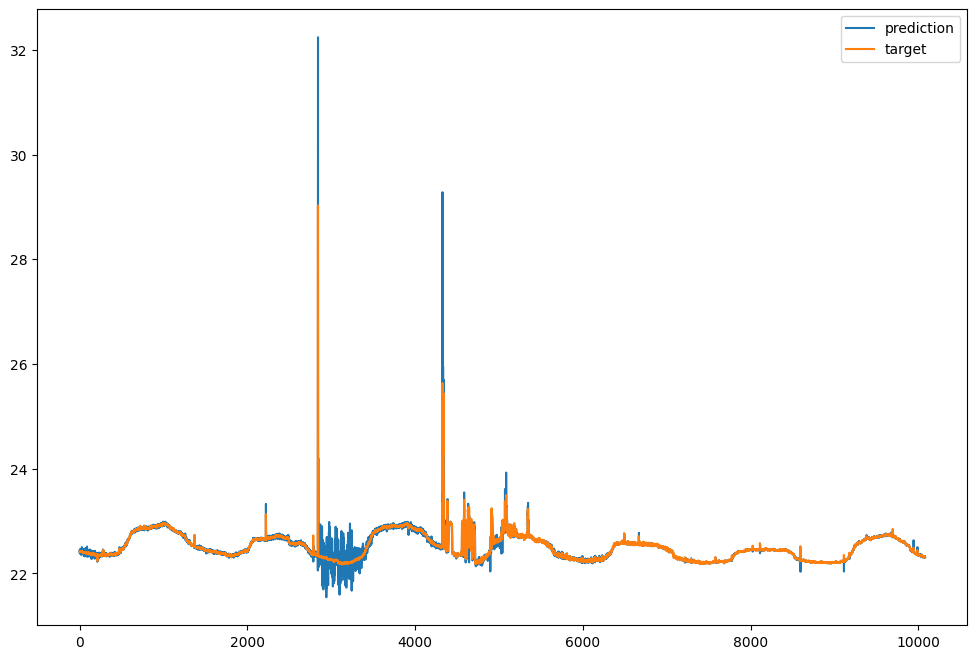

In [29]:
target=list(target.values.reshape(-1))

fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

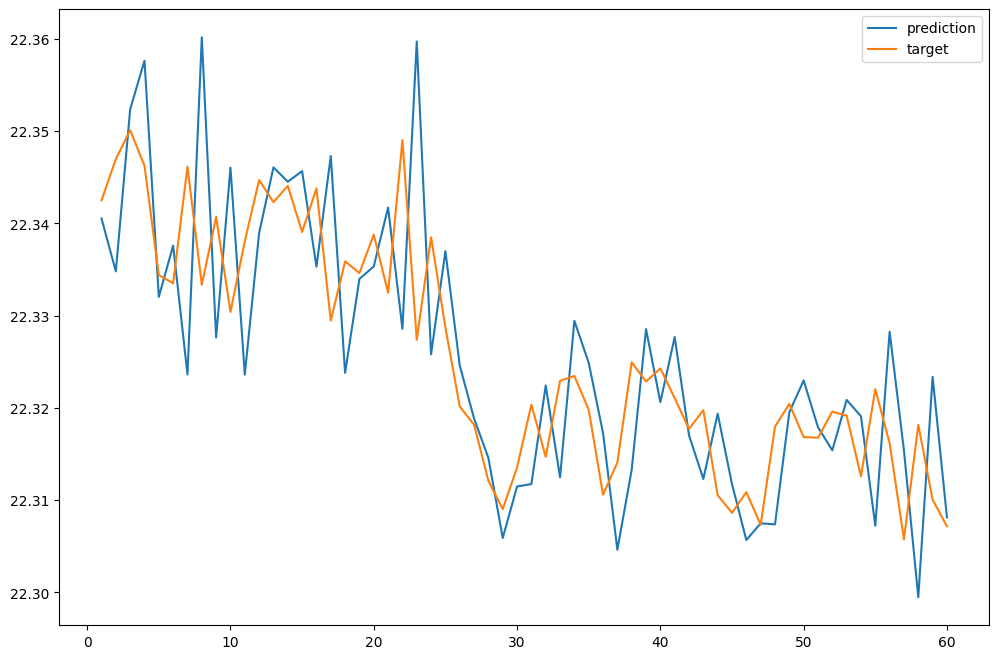

In [30]:
target = data.iloc[-split:]
target=list(target.values.reshape(-1))
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

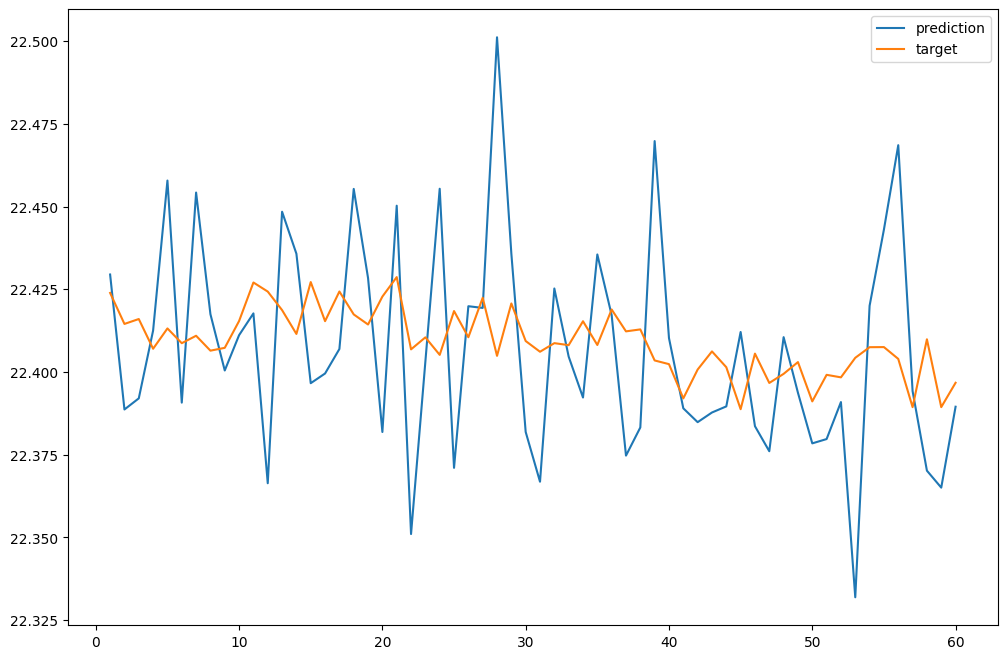

In [31]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[:60],label='prediction')
axes.plot(np.arange(1,61),target[:60],label='target')
axes.legend()

In [32]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                      FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),
                    FloatTensor(np.array(target).reshape(-1,1))).item()*100,'%')

SMAPE 0.14457679353654385 %
RMSE 0.13090167939662933
MAPE 0.14494616771116853 %


In [33]:
target

[22.423888,
 22.41452,
 22.416,
 22.407016,
 22.41316,
 22.408696,
 22.410944,
 22.40644,
 22.407296,
 22.4154,
 22.42704,
 22.424296,
 22.418696,
 22.411496,
 22.427168,
 22.415352,
 22.42432,
 22.417392,
 22.414344,
 22.422784,
 22.428672,
 22.406832,
 22.410464,
 22.405168,
 22.418408,
 22.410496,
 22.422424,
 22.404872,
 22.420704,
 22.409352,
 22.406112,
 22.408712,
 22.408104,
 22.415328,
 22.408152,
 22.41888,
 22.412272,
 22.412864,
 22.40348,
 22.402368,
 22.392016,
 22.400728,
 22.406216,
 22.40144,
 22.388752,
 22.405544,
 22.39668,
 22.399432,
 22.402984,
 22.391112,
 22.399136,
 22.398376,
 22.40428,
 22.407488,
 22.40752,
 22.403952,
 22.389368,
 22.40988,
 22.389376,
 22.396736,
 22.39828,
 22.396968,
 22.396136,
 22.39768,
 22.4022,
 22.400816,
 22.3964,
 22.406192,
 22.401976,
 22.395248,
 22.395192,
 22.399312,
 22.384072,
 22.402024,
 22.38908,
 22.379896,
 22.384848,
 22.38972,
 22.393768,
 22.387976,
 22.399872,
 22.393088,
 22.400208,
 22.383432,
 22.379728,
 22.3